In [2]:
!pip install kagglehub --quiet

import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import hashlib


c:\Users\jobet\emotion_detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATASET_NAME = "ananthu017/emotion-detection-fer"

dataset_path = kagglehub.dataset_download(DATASET_NAME)

print("Dataset downloaded to:")
print(dataset_path)


Dataset downloaded to:
C:\Users\jobet\.cache\kagglehub\datasets\ananthu017\emotion-detection-fer\versions\1


In [4]:
def explore_structure(base_path):
    for root, dirs, files in os.walk(base_path):
        print(f"\nDirectory: {root}")
        print(f"Subfolders: {dirs}")
        print(f"Sample files: {files[:5]}")
        break
explore_structure(dataset_path)


Directory: C:\Users\jobet\.cache\kagglehub\datasets\ananthu017\emotion-detection-fer\versions\1
Subfolders: ['test', 'train']
Sample files: []


In [5]:
def detect_splits(base_path):
    splits = []
    for folder in os.listdir(base_path):
        full_path = os.path.join(base_path, folder)
        if os.path.isdir(full_path):
            splits.append(folder)
    return splits

splits = detect_splits(dataset_path)
print("Detected Splits:", splits)


Detected Splits: ['test', 'train']


In [6]:
def count_images(base_path):
    data = []
    
    for split in os.listdir(base_path):
        split_path = os.path.join(base_path, split)
        if os.path.isdir(split_path):
            for emotion in os.listdir(split_path):
                emotion_path = os.path.join(split_path, emotion)
                if os.path.isdir(emotion_path):
                    count = len(os.listdir(emotion_path))
                    data.append([split, emotion, count])
    
    return pd.DataFrame(data, columns=["Split", "Emotion", "Count"])

df_counts = count_images(dataset_path)
df_counts


,Split,Emotion,Count
0,test,angry,958
1,test,disgusted,111
2,test,fearful,1024
3,test,happy,1774
4,test,neutral,1233
5,test,sad,1247
6,test,surprised,831
7,train,angry,3995
8,train,disgusted,436
9,train,fearful,4097


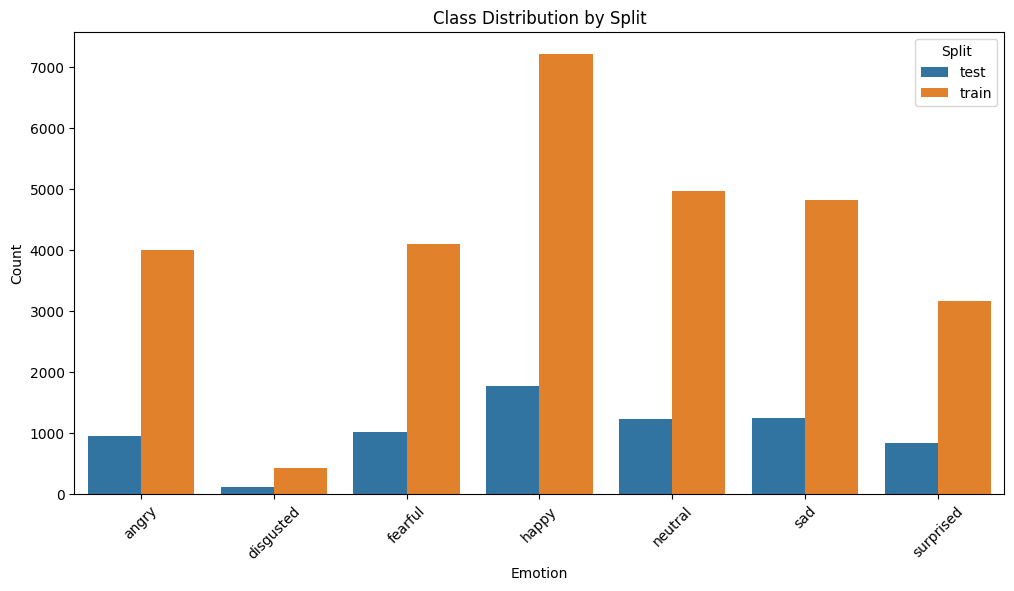

In [7]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_counts, x="Emotion", y="Count", hue="Split")
plt.xticks(rotation=45)
plt.title("Class Distribution by Split")
plt.show()


In [8]:
def check_corrupt_images(base_path, sample_limit=5000):
    corrupt_files = []
    checked = 0
    
    for root, _, files in os.walk(base_path):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()
                checked += 1
                if checked >= sample_limit:
                    return corrupt_files
            except:
                corrupt_files.append(img_path)
    
    return corrupt_files

corrupt_images = check_corrupt_images(dataset_path)
print("Corrupt images found:", len(corrupt_images))


Corrupt images found: 0


In [9]:
image_sizes = []

for root, _, files in os.walk(dataset_path):
    for file in files[:1000]:
        try:
            img = Image.open(os.path.join(root, file))
            image_sizes.append(img.size)
        except:
            continue

size_df = pd.DataFrame(image_sizes, columns=["Width", "Height"])
size_df.describe()


,Width,Height
count,12336.0,12336.0
mean,48.0,48.0
std,0.0,0.0
min,48.0,48.0
25%,48.0,48.0
50%,48.0,48.0
75%,48.0,48.0
max,48.0,48.0


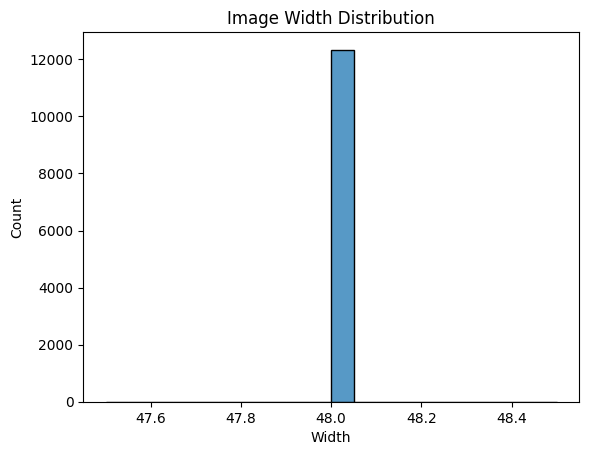

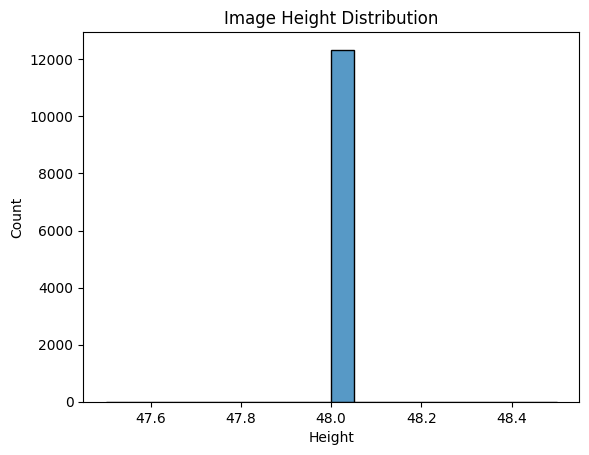

In [10]:
sns.histplot(size_df["Width"], bins=20)
plt.title("Image Width Distribution")
plt.show()

sns.histplot(size_df["Height"], bins=20)
plt.title("Image Height Distribution")
plt.show()


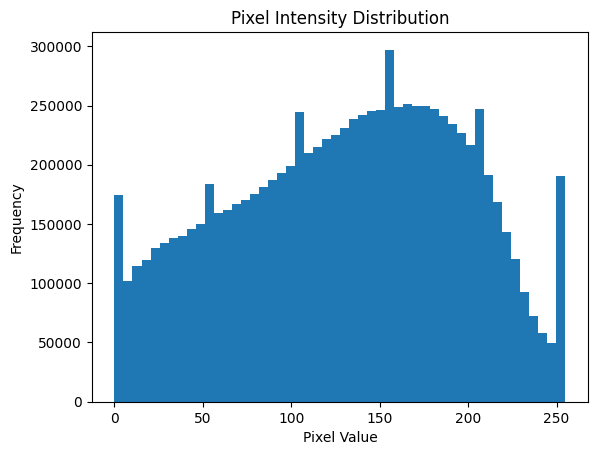

In [11]:
sample_pixels = []

for root, _, files in os.walk(dataset_path):
    for file in files[:300]:
        try:
            img = Image.open(os.path.join(root, file)).convert("L")
            sample_pixels.append(np.array(img).flatten())
        except:
            continue

pixel_values = np.concatenate(sample_pixels)

plt.hist(pixel_values, bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


In [16]:
import hashlib
from collections import defaultdict

def file_hash(path, chunk_size=8192):
    hasher = hashlib.md5()
    with open(path, "rb") as f:
        while chunk := f.read(chunk_size):
            hasher.update(chunk)
    return hasher.hexdigest()

def collect_hashes(split_name):
    hashes = {}
    split_path = os.path.join(dataset_path, split_name)
    
    for root, _, files in os.walk(split_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                h = file_hash(file_path)
                hashes[h] = file_path
            except:
                continue
    return hashes


leakage_report = []

if "train" in splits and "test" in splits:
    
    train_hashes = collect_hashes("train")
    test_hashes = collect_hashes("test")
    
    common_hashes = set(train_hashes.keys()).intersection(test_hashes.keys())
    
    for h in common_hashes:
        leakage_report.append({
            "train_file": train_hashes[h],
            "test_file": test_hashes[h],
            "hash": h
        })

    print("========== DATA LEAKAGE REPORT ==========")
    print("Duplicate files found:", len(leakage_report))
    print("=========================================")

    if leakage_report:
        import pandas as pd
        display(pd.DataFrame(leakage_report).head())


========== DATA LEAKAGE REPORT ==========
Duplicate files found: 531


,train_file,test_file,hash
0,C:\Users\jobet\.cache\kagglehub\datasets\anant...,C:\Users\jobet\.cache\kagglehub\datasets\anant...,50afb2acc0e6c95ee4897be4efc70c36
1,C:\Users\jobet\.cache\kagglehub\datasets\anant...,C:\Users\jobet\.cache\kagglehub\datasets\anant...,f60a9018c9b4c654403ff11ab7762151
2,C:\Users\jobet\.cache\kagglehub\datasets\anant...,C:\Users\jobet\.cache\kagglehub\datasets\anant...,7f46c6b4e41d1a5064d19cfa7a3eab77
3,C:\Users\jobet\.cache\kagglehub\datasets\anant...,C:\Users\jobet\.cache\kagglehub\datasets\anant...,cf445f5fbf6d854b6c4fccd1962616b8
4,C:\Users\jobet\.cache\kagglehub\datasets\anant...,C:\Users\jobet\.cache\kagglehub\datasets\anant...,02322c2d3c60843dd2d7de8dcdfee525


In [14]:
total_images = df_counts["Count"].sum()

print("========== DATASET REPORT ==========")
print("Dataset Source: KaggleHub")
print("Dataset Name:", DATASET_NAME)
print("Total Images:", total_images)
print("Number of Classes:", df_counts["Emotion"].nunique())
print("Splits:", splits)
print("\nDistribution by Split:")
print(df_counts.groupby("Split")["Count"].sum())
print("====================================")


========== DATASET REPORT ==========
Dataset Source: KaggleHub
Dataset Name: ananthu017/emotion-detection-fer
Total Images: 35887
Number of Classes: 7
Splits: ['test', 'train']

Distribution by Split:
Split
test      7178
train    28709
Name: Count, dtype: int64
